In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.utils.data import  DataLoader,random_split
from torchvision import datasets,transforms
import torch.nn as nn
import itertools
import sys
sys.path.append('/content/drive/MyDrive/mask-classfication')
from CustomModel import MaskNet , MaskNetV2
from MaskDataset import MaskImageDataset
import numpy as np

import matplotlib.pyplot as plt
import os
import torch, torchvision


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def loadDataset(DATASET_DIR,data_path):
    
    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

    full_dataset = MaskImageDataset(data_path, DATASET_DIR, transform=transform)                                   
   
    return DataLoader(full_dataset, batch_size=32, shuffle=True)

In [ ]:
CLASSES = ['Cloth-Mask','N95-Mask','N95with Valve-Mask','No-Mask','Surgical-Mask']
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

data_path_MALE = "/content/drive/MyDrive/mask-classfication/Male.csv"
data_path_FEMALE = "/content/drive/MyDrive/mask-classfication/Female.csv"
data_path_KIDS = "/content/drive/MyDrive/mask-classfication/Kids.csv"
data_path_MEN = "/content/drive/MyDrive/mask-classfication/Adults.csv"
data_path_ELDERS = "/content/drive/MyDrive/mask-classfication/Elder.csv"

DATASET_MALE = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Gender/Male'
DATASET_FEMALE = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Gender/Female'

DATASET_KIDS = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Age/Kids'
DATASET_MEN = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Age/Adults'
DATASET_ELDERS ='/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Age/Elder'

In [ ]:
from torch.nn.functional import cross_entropy
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot
def test_model(model,test_data,DEVICE):
    #print('RBYRY')  
    testing_loss = 0
    correct_prediction = 0 
    data_size = 0
    prediction1=[]
    #print('RBYRY1')
    #print(test_data)
        
    for images, labels in test_data:
            #print('RBYRY134')
            images = images.to(device)
            labels = labels.to(device)          
            data_size += len(images)
            prediction = model(images)
            
            prediction1.append(prediction)
            
            testing_loss += cross_entropy(prediction, labels).item()
            correct_prediction += (prediction.argmax(dim=1) == labels).sum().item()


    test_accuracy = correct_prediction/data_size
    testing_loss = testing_loss/data_size

    print('\nTesting:')
    print(f"Correct prediction: {correct_prediction}/{data_size} and accuracy: {test_accuracy} and loss: {testing_loss}")
    #print(prediction1)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def get_labels_N_prediction(model,loader,DEVICE):
    all_labels = []
    all_prediction = []

    for batch in loader:
        images, labels = batch
        images = images.to(DEVICE)

        prediction = model(images).to(torch.device("cpu")).argmax(dim=1).detach().numpy()
        labels = labels.to(torch.device("cpu")).detach().numpy()

        all_prediction = np.append(all_prediction,prediction)
        all_labels = np.append(all_labels,labels)

    return [all_labels,all_prediction]

def display_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conf_matrix)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def evaluate(model, DATA,device):
    #print('DVDV')
    test_model(model,DATA,device)
    #print('MALE')
    with torch.no_grad():
        labels_N_prediction = get_labels_N_prediction(model, DATA, device)

    print(classification_report(labels_N_prediction[0], labels_N_prediction[1], target_names =CLASSES))
    conf_matrix = confusion_matrix(labels_N_prediction[0], labels_N_prediction[1])
    plt.figure(figsize=(10, 10))
    display_confusion_matrix(conf_matrix,CLASSES)
    
    y_pred =labels_N_prediction[1]
    y_test =labels_N_prediction[0]
    disp = PrecisionRecallDisplay(precision=precision_recall_fscore_support(y_test, y_pred)[0],recall=precision_recall_fscore_support(y_test, y_pred)[1])
    disp.plot( marker='.')
    matplotlib.pyplot.show()
    matplotlib.pyplot.savefig('Precision vs Recall.png')

MALE

Testing:
Correct prediction: 22/24 and accuracy: 0.9166666666666666 and loss: 0.006568064913153648
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      1.00      1.00         5
          N95-Mask       1.00      1.00      1.00         4
N95with Valve-Mask       1.00      0.75      0.86         4
           No-Mask       1.00      1.00      1.00         6
     Surgical-Mask       0.83      1.00      0.91         5

          accuracy                           0.96        24
         macro avg       0.97      0.95      0.95        24
      weighted avg       0.97      0.96      0.96        24

Confusion matrix, without normalization
[[5 0 0 0 0]
 [0 4 0 0 0]
 [0 0 3 0 1]
 [0 0 0 6 0]
 [0 0 0 0 5]]


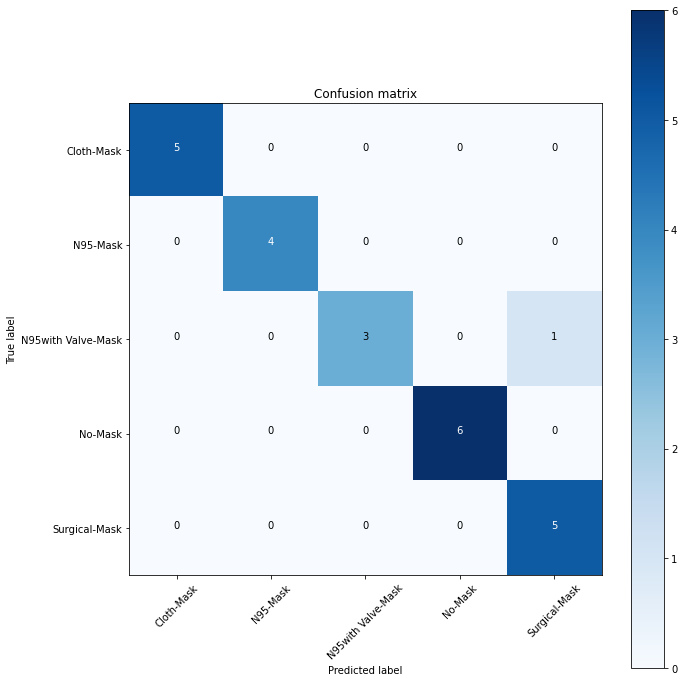

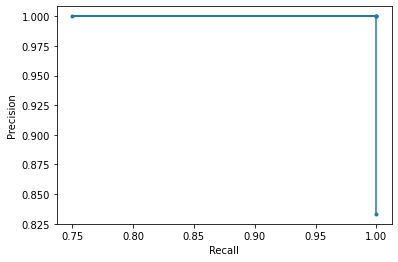

---------------------------
FEMALE

Testing:
Correct prediction: 36/39 and accuracy: 0.9230769230769231 and loss: 0.012245329526754526
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      0.78      0.88         9
          N95-Mask       0.88      0.78      0.82         9
N95with Valve-Mask       0.73      1.00      0.84         8
           No-Mask       1.00      0.86      0.92         7
     Surgical-Mask       0.86      1.00      0.92         6

          accuracy                           0.87        39
         macro avg       0.89      0.88      0.88        39
      weighted avg       0.89      0.87      0.87        39

Confusion matrix, without normalization
[[7 0 2 0 0]
 [0 7 1 0 1]
 [0 0 8 0 0]
 [0 1 0 6 0]
 [0 0 0 0 6]]


<Figure size 432x288 with 0 Axes>

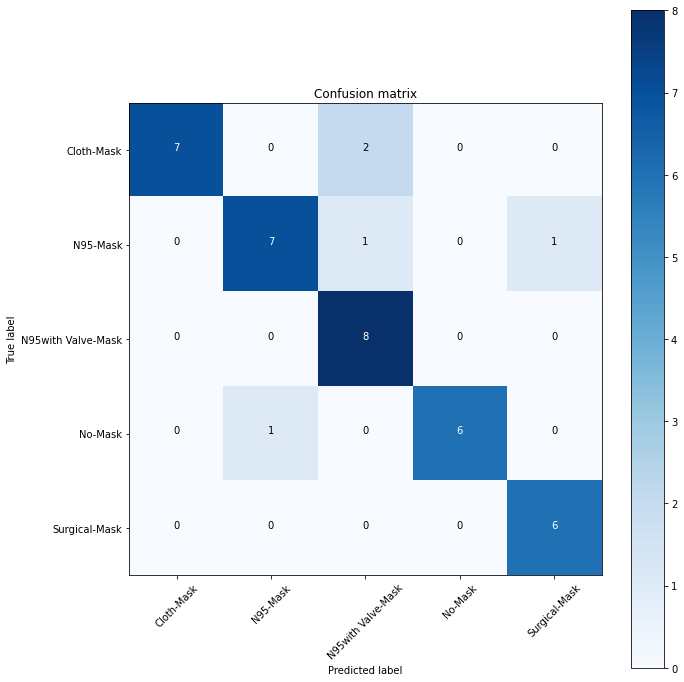

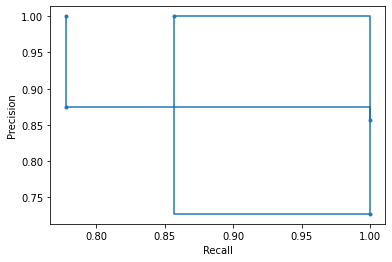

---------------------------
KIDS

Testing:
Correct prediction: 55/60 and accuracy: 0.9166666666666666 and loss: 0.01224370946486791
                    precision    recall  f1-score   support

        Cloth-Mask       0.86      0.83      0.84        23
          N95-Mask       1.00      0.50      0.67         2
N95with Valve-Mask       0.62      0.83      0.71         6
           No-Mask       1.00      0.92      0.96        25
     Surgical-Mask       0.67      1.00      0.80         4

          accuracy                           0.87        60
         macro avg       0.83      0.82      0.80        60
      weighted avg       0.89      0.87      0.87        60

Confusion matrix, without normalization
[[19  0  3  0  1]
 [ 0  1  0  0  1]
 [ 1  0  5  0  0]
 [ 2  0  0 23  0]
 [ 0  0  0  0  4]]


<Figure size 432x288 with 0 Axes>

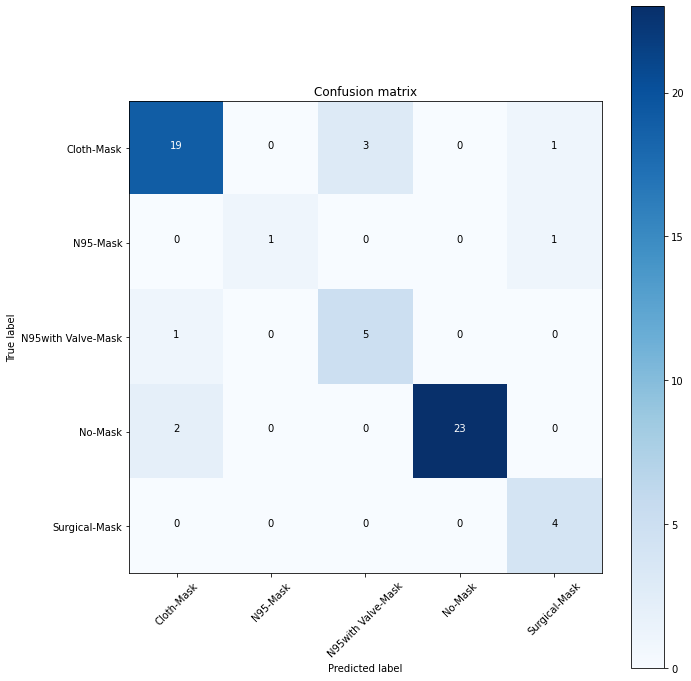

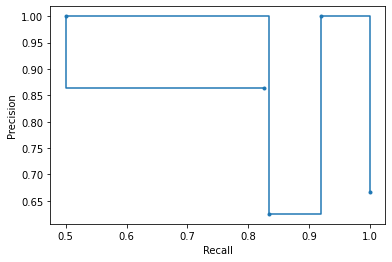

---------------------------
ADULTS

Testing:
Correct prediction: 154/171 and accuracy: 0.9005847953216374 and loss: 0.016240646093212373
                    precision    recall  f1-score   support

        Cloth-Mask       0.81      1.00      0.89        21
          N95-Mask       0.80      0.83      0.82        24
N95with Valve-Mask       0.77      0.96      0.86        25
           No-Mask       1.00      0.82      0.90        56
     Surgical-Mask       0.95      0.91      0.93        45

          accuracy                           0.89       171
         macro avg       0.87      0.91      0.88       171
      weighted avg       0.90      0.89      0.89       171

Confusion matrix, without normalization
[[21  0  0  0  0]
 [ 2 20  2  0  0]
 [ 0  1 24  0  0]
 [ 2  2  4 46  2]
 [ 1  2  1  0 41]]


<Figure size 432x288 with 0 Axes>

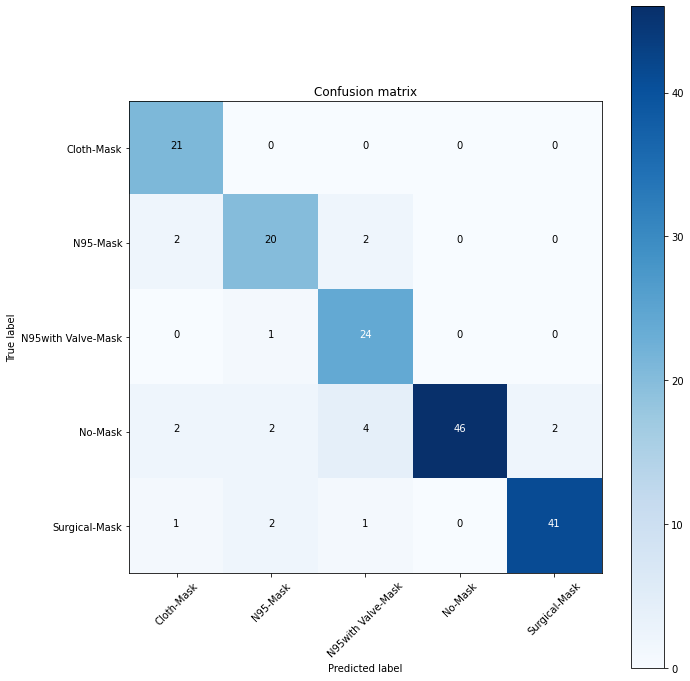

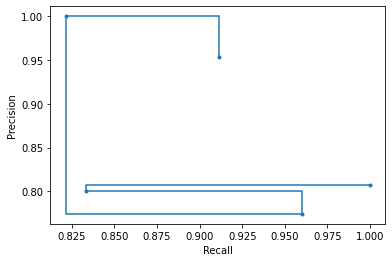

---------------------------
ELDER

Testing:
Correct prediction: 34/37 and accuracy: 0.918918918918919 and loss: 0.10431274087042422
                    precision    recall  f1-score   support

        Cloth-Mask       0.80      0.89      0.84         9
          N95-Mask       1.00      0.60      0.75         5
N95with Valve-Mask       0.86      1.00      0.92         6
           No-Mask       1.00      0.88      0.93         8
     Surgical-Mask       0.90      1.00      0.95         9

          accuracy                           0.89        37
         macro avg       0.91      0.87      0.88        37
      weighted avg       0.90      0.89      0.89        37

Confusion matrix, without normalization
[[8 0 1 0 0]
 [1 3 0 0 1]
 [0 0 6 0 0]
 [1 0 0 7 0]
 [0 0 0 0 9]]


<Figure size 432x288 with 0 Axes>

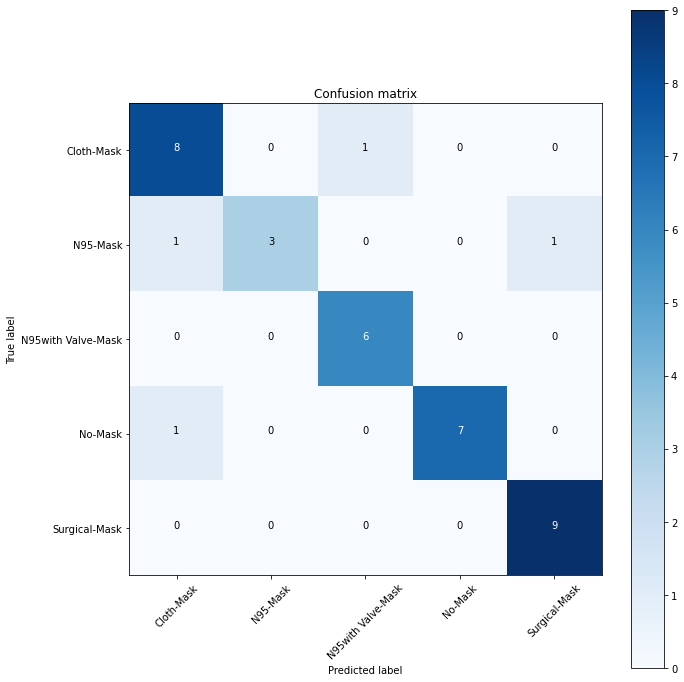

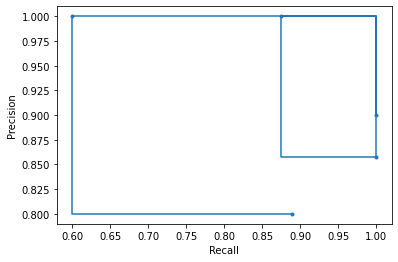

---------------------------


<Figure size 432x288 with 0 Axes>

In [ ]:

model = MaskNetV2()
model = model.to(device)
path = F"/content/drive/MyDrive/mask-classfication/saved_models/masknetv2_k_fold::24_full.pt"
model = torch.load(path,torch.device('cpu'))
MALE = loadDataset(DATASET_MALE,data_path_MALE)
FEMALE = loadDataset(DATASET_FEMALE,data_path_FEMALE)
TEEN = loadDataset(DATASET_KIDS,data_path_KIDS)
MEN = loadDataset(DATASET_MEN,data_path_MEN)
OLD = loadDataset(DATASET_ELDERS,data_path_ELDERS)

print('MALE')
evaluate(model, MALE,device)
print('---------------------------')

print('FEMALE')
evaluate(model, FEMALE,device)
print('---------------------------')


print('KIDS')
evaluate(model, TEEN,device)
print('---------------------------')

print('ADULTS')
evaluate(model, MEN,device)
print('---------------------------')

print('ELDER')
evaluate(model, OLD,device)
print('---------------------------')

Prediction : No Mask


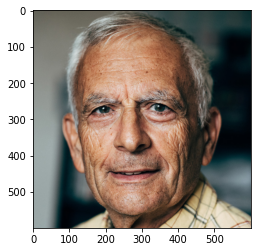

In [ ]:
import torch

from torchvision import transforms
from PIL import Image



def predictImage(model, imagePath, device, labels={0:'cloth', 1:'N95', 2:'N95 with valve', 3:'No Mask', 4:'Surgical'}):
    
    
    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])
    image = Image.open(imagePath).convert('RGB')
    imageD = Image.open(imagePath).convert('RGB')
    
    image = transform(image)
    
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
    pred = output.argmax(dim=1).cpu().numpy()
    #print(pred)
    
    plt.imshow(imageD)    
    print("Prediction : " + labels[pred[0]])
    
img_path = "/content/drive/MyDrive/mask-classfication/Dataset/NoMask-292.png"

predictImage(model, img_path, "cpu")

# New Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.utils.data import  DataLoader,random_split
from torchvision import datasets,transforms
import torch.nn as nn
import itertools
import sys
sys.path.append('/content/drive/MyDrive/mask-classfication')
from CustomModel import MaskNet , MaskNetV2
from MaskDataset import MaskImageDataset
import numpy as np

import matplotlib.pyplot as plt
import os
import torch, torchvision


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
def loadDataset(DATASET_DIR,data_path):
    
    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

    full_dataset = MaskImageDataset(data_path, DATASET_DIR, transform=transform)                                   
   
    return DataLoader(full_dataset, batch_size=32, shuffle=True)

In [3]:
CLASSES = ['Cloth-Mask','N95-Mask','N95with Valve-Mask','No-Mask','Surgical-Mask']
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

data_path_MALE = "/content/drive/MyDrive/mask-classfication/Male.csv"
data_path_FEMALE = "/content/drive/MyDrive/mask-classfication/Female.csv"
data_path_KIDS = "/content/drive/MyDrive/mask-classfication/Kids.csv"
data_path_MEN = "/content/drive/MyDrive/mask-classfication/Adults.csv"
data_path_ELDERS = "/content/drive/MyDrive/mask-classfication/Elder.csv"

DATASET_MALE = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Gender/Male'
DATASET_FEMALE = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Gender/Female'

DATASET_KIDS = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Age/Kids'
DATASET_MEN = '/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Age/Adults'
DATASET_ELDERS ='/content/drive/MyDrive/mask-classfication/Dataset- kfold/Postbias/Age/Elder'

In [4]:
from torch.nn.functional import cross_entropy
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot
def test_model(model,test_data,DEVICE):
    #print('RBYRY')  
    testing_loss = 0
    correct_prediction = 0 
    data_size = 0
    prediction1=[]
    #print('RBYRY1')
    #print(test_data)
        
    for images, labels in test_data:
            #print('RBYRY134')
            images = images.to(device)
            labels = labels.to(device)          
            data_size += len(images)
            prediction = model(images)
            
            prediction1.append(prediction)
            
            testing_loss += cross_entropy(prediction, labels).item()
            correct_prediction += (prediction.argmax(dim=1) == labels).sum().item()


    test_accuracy = correct_prediction/data_size
    testing_loss = testing_loss/data_size

    print('\nTesting:')
    print(f"Correct prediction: {correct_prediction}/{data_size} and accuracy: {test_accuracy} and loss: {testing_loss}")
    return test_accuracy
    #print(prediction1)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def get_labels_N_prediction(model,loader,DEVICE):
    all_labels = []
    all_prediction = []

    for batch in loader:
        images, labels = batch
        images = images.to(DEVICE)

        prediction = model(images).to(torch.device("cpu")).argmax(dim=1).detach().numpy()
        labels = labels.to(torch.device("cpu")).detach().numpy()

        all_prediction = np.append(all_prediction,prediction)
        all_labels = np.append(all_labels,labels)

    return [all_labels,all_prediction]

def display_confusion_matrix(conf_matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conf_matrix)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def evaluate2(model, DATA,device):
    #print('DVDV')
    t_acc = test_model(model,DATA,device)
    #print('MALE')
    with torch.no_grad():
        labels_N_prediction = get_labels_N_prediction(model, DATA, device)

    print(classification_report(labels_N_prediction[0], labels_N_prediction[1], target_names =CLASSES))
    conf_matrix = confusion_matrix(labels_N_prediction[0], labels_N_prediction[1])
    plt.figure(figsize=(10, 10))
    display_confusion_matrix(conf_matrix,CLASSES)
    
    y_pred =labels_N_prediction[1]
    y_test =labels_N_prediction[0]
    #disp = PrecisionRecallDisplay(precision=precision_recall_fscore_support(y_test, y_pred)[0],recall=precision_recall_fscore_support(y_test, y_pred)[1])
    #isp.plot( marker='.')
    #matplotlib.pyplot.show()
    #matplotlib.pyplot.savefig('Precision vs Recall.png')

    prec, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)

    return (t_acc, prec, recall, fscore)

In [5]:
MALE = loadDataset(DATASET_MALE,data_path_MALE)
FEMALE = loadDataset(DATASET_FEMALE,data_path_FEMALE)
TEEN = loadDataset(DATASET_KIDS,data_path_KIDS)
MEN = loadDataset(DATASET_MEN,data_path_MEN)
OLD = loadDataset(DATASET_ELDERS,data_path_ELDERS)

In [6]:
bias_measures_male = []
bias_measures_female = []
bias_measures_teen = []
bias_measures_adult = []
bias_measures_old = []

For Model 0 

MALE

Testing:
Correct prediction: 20/24 and accuracy: 0.8333333333333334 and loss: 0.018106387307246525
                    precision    recall  f1-score   support

        Cloth-Mask       0.43      0.60      0.50         5
          N95-Mask       0.67      0.50      0.57         4
N95with Valve-Mask       0.50      0.75      0.60         4
           No-Mask       1.00      0.50      0.67         6
     Surgical-Mask       0.60      0.60      0.60         5

          accuracy                           0.58        24
         macro avg       0.64      0.59      0.59        24
      weighted avg       0.66      0.58      0.59        24

Confusion matrix, without normalization
[[3 0 1 0 1]
 [0 2 1 0 1]
 [0 1 3 0 0]
 [3 0 0 3 0]
 [1 0 1 0 3]]


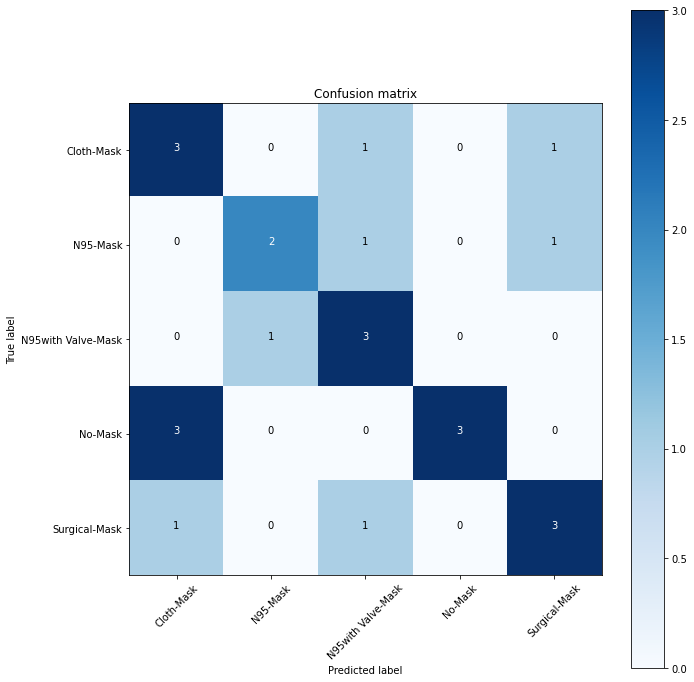

---------------------------
FEMALE

Testing:
Correct prediction: 36/39 and accuracy: 0.9230769230769231 and loss: 0.012127343278664809
                    precision    recall  f1-score   support

        Cloth-Mask       0.89      0.89      0.89         9
          N95-Mask       1.00      0.78      0.88         9
N95with Valve-Mask       0.89      1.00      0.94         8
           No-Mask       1.00      0.71      0.83         7
     Surgical-Mask       0.67      1.00      0.80         6

          accuracy                           0.87        39
         macro avg       0.89      0.88      0.87        39
      weighted avg       0.90      0.87      0.87        39

Confusion matrix, without normalization
[[8 0 0 0 1]
 [0 7 1 0 1]
 [0 0 8 0 0]
 [1 0 0 5 1]
 [0 0 0 0 6]]


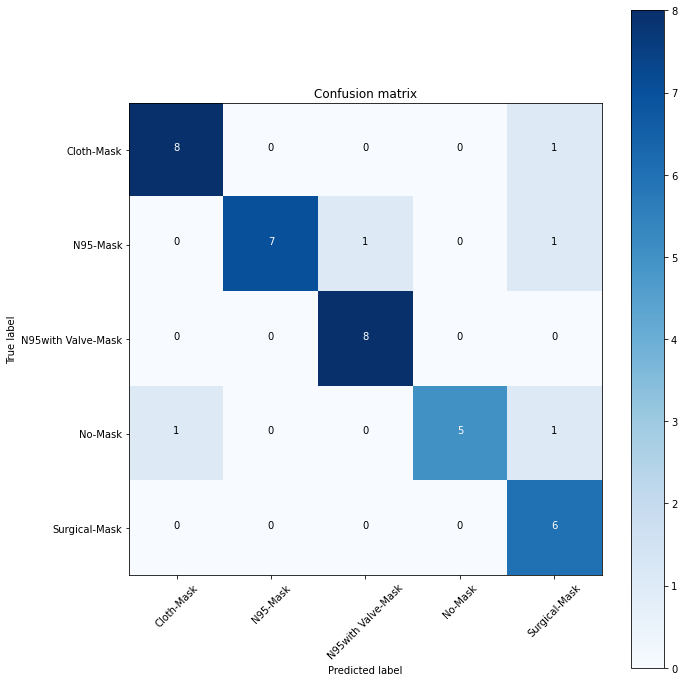

---------------------------
KIDS

Testing:
Correct prediction: 55/60 and accuracy: 0.9166666666666666 and loss: 0.008354655901590983
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      0.87      0.93        23
          N95-Mask       1.00      1.00      1.00         2
N95with Valve-Mask       0.75      1.00      0.86         6
           No-Mask       1.00      1.00      1.00        25
     Surgical-Mask       0.80      1.00      0.89         4

          accuracy                           0.95        60
         macro avg       0.91      0.97      0.94        60
      weighted avg       0.96      0.95      0.95        60

Confusion matrix, without normalization
[[20  0  2  0  1]
 [ 0  2  0  0  0]
 [ 0  0  6  0  0]
 [ 0  0  0 25  0]
 [ 0  0  0  0  4]]


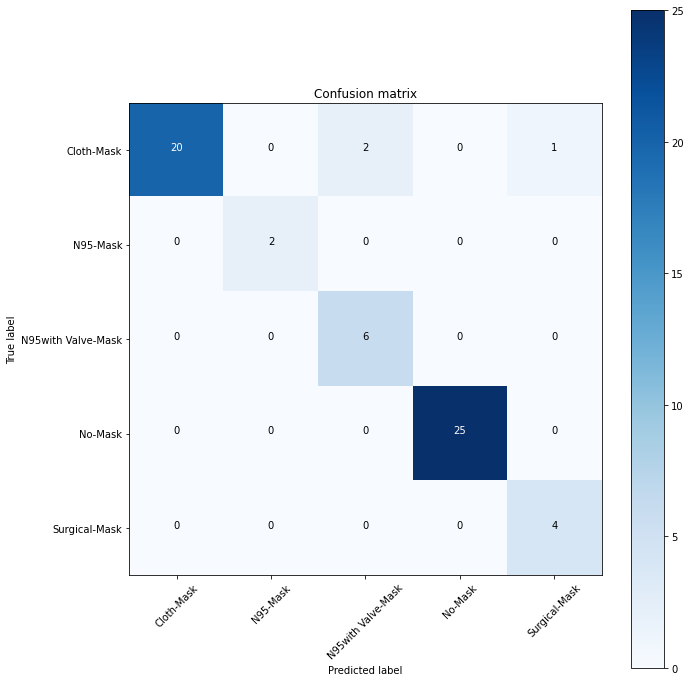

---------------------------
ADULTS

Testing:
Correct prediction: 151/171 and accuracy: 0.8830409356725146 and loss: 0.014100263559678841
                    precision    recall  f1-score   support

        Cloth-Mask       0.69      0.86      0.77        21
          N95-Mask       0.86      0.79      0.83        24
N95with Valve-Mask       0.71      0.88      0.79        25
           No-Mask       1.00      0.89      0.94        56
     Surgical-Mask       0.88      0.82      0.85        45

          accuracy                           0.85       171
         macro avg       0.83      0.85      0.83       171
      weighted avg       0.87      0.85      0.86       171

Confusion matrix, without normalization
[[18  0  1  0  2]
 [ 3 19  2  0  0]
 [ 1  1 22  0  1]
 [ 1  0  3 50  2]
 [ 3  2  3  0 37]]


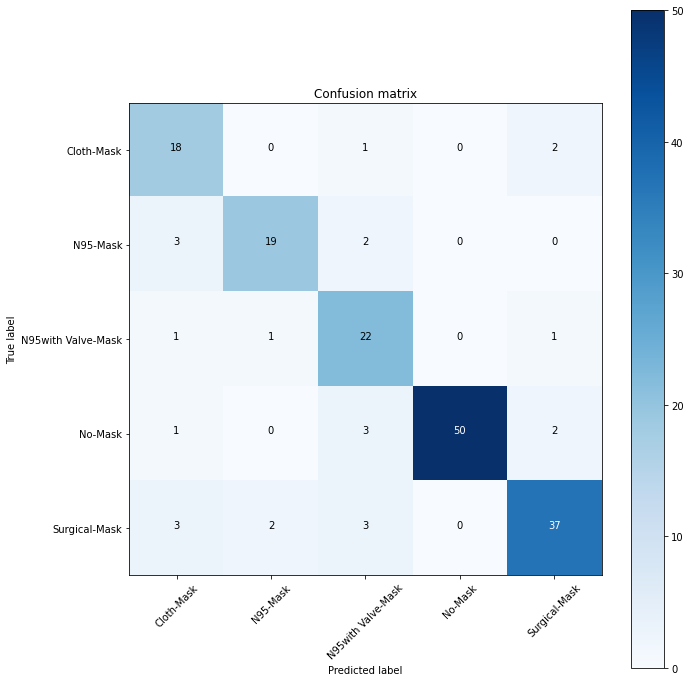

---------------------------
ELDER

Testing:
Correct prediction: 33/37 and accuracy: 0.8918918918918919 and loss: 0.023325097721976204
                    precision    recall  f1-score   support

        Cloth-Mask       0.89      0.89      0.89         9
          N95-Mask       0.50      0.80      0.62         5
N95with Valve-Mask       0.80      0.67      0.73         6
           No-Mask       1.00      0.88      0.93         8
     Surgical-Mask       0.88      0.78      0.82         9

          accuracy                           0.81        37
         macro avg       0.81      0.80      0.80        37
      weighted avg       0.84      0.81      0.82        37

Confusion matrix, without normalization
[[8 0 1 0 0]
 [1 4 0 0 0]
 [0 1 4 0 1]
 [0 1 0 7 0]
 [0 2 0 0 7]]


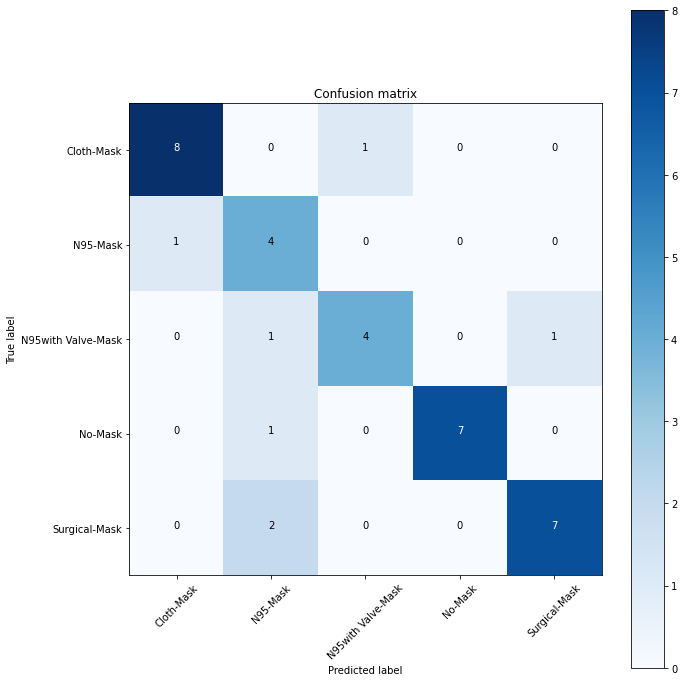

---------------------------
For Model 1 

MALE

Testing:
Correct prediction: 21/24 and accuracy: 0.875 and loss: 0.02516176551580429
                    precision    recall  f1-score   support

        Cloth-Mask       0.83      1.00      0.91         5
          N95-Mask       0.80      1.00      0.89         4
N95with Valve-Mask       1.00      0.75      0.86         4
           No-Mask       1.00      0.83      0.91         6
     Surgical-Mask       1.00      1.00      1.00         5

          accuracy                           0.92        24
         macro avg       0.93      0.92      0.91        24
      weighted avg       0.93      0.92      0.92        24

Confusion matrix, without normalization
[[5 0 0 0 0]
 [0 4 0 0 0]
 [0 1 3 0 0]
 [1 0 0 5 0]
 [0 0 0 0 5]]


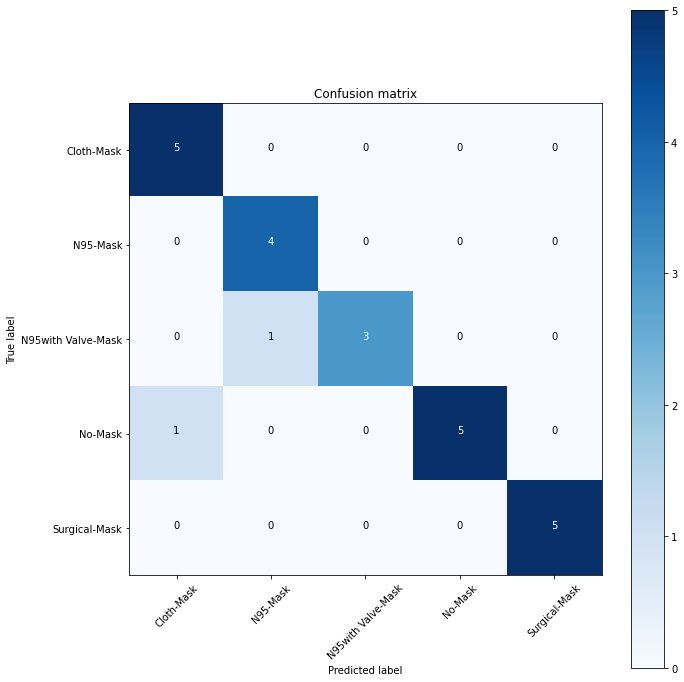

---------------------------
FEMALE

Testing:
Correct prediction: 33/39 and accuracy: 0.8461538461538461 and loss: 0.013949149359877292
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      0.89      0.94         9
          N95-Mask       0.80      0.89      0.84         9
N95with Valve-Mask       0.88      0.88      0.88         8
           No-Mask       0.88      1.00      0.93         7
     Surgical-Mask       1.00      0.83      0.91         6

          accuracy                           0.90        39
         macro avg       0.91      0.90      0.90        39
      weighted avg       0.91      0.90      0.90        39

Confusion matrix, without normalization
[[8 0 0 1 0]
 [0 8 1 0 0]
 [0 1 7 0 0]
 [0 0 0 7 0]
 [0 1 0 0 5]]


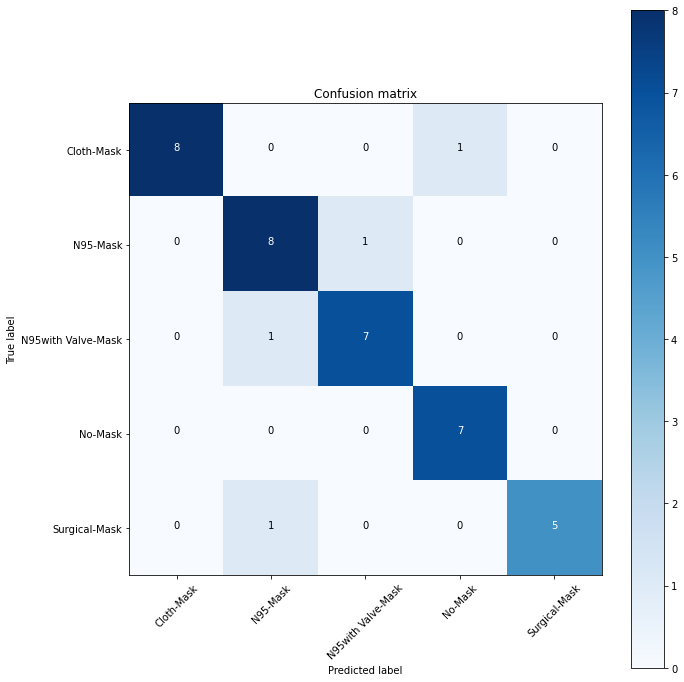

---------------------------
KIDS

Testing:
Correct prediction: 51/60 and accuracy: 0.85 and loss: 0.017395480473836263
                    precision    recall  f1-score   support

        Cloth-Mask       0.95      0.78      0.86        23
          N95-Mask       0.17      0.50      0.25         2
N95with Valve-Mask       0.83      0.83      0.83         6
           No-Mask       1.00      0.92      0.96        25
     Surgical-Mask       0.50      0.75      0.60         4

          accuracy                           0.83        60
         macro avg       0.69      0.76      0.70        60
      weighted avg       0.90      0.83      0.86        60

Confusion matrix, without normalization
[[18  2  1  0  2]
 [ 1  1  0  0  0]
 [ 0  1  5  0  0]
 [ 0  1  0 23  1]
 [ 0  1  0  0  3]]


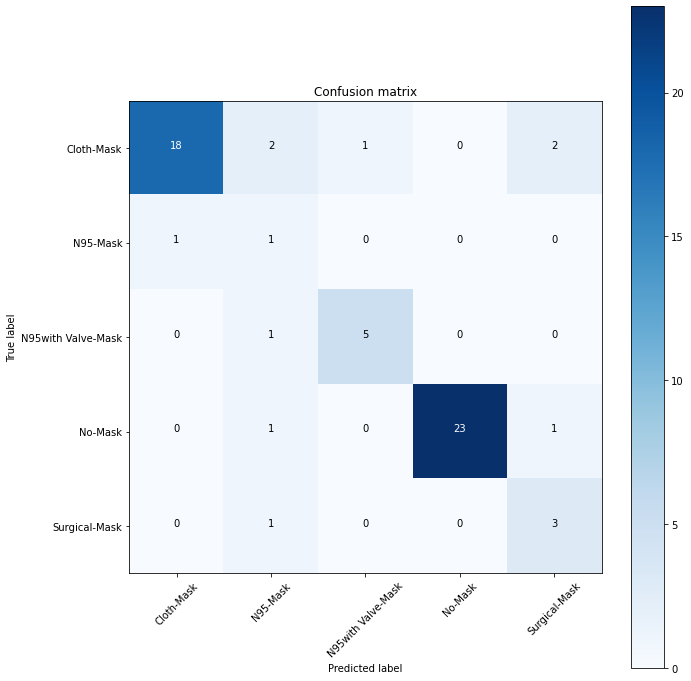

---------------------------
ADULTS

Testing:
Correct prediction: 149/171 and accuracy: 0.8713450292397661 and loss: 0.018080738552829677
                    precision    recall  f1-score   support

        Cloth-Mask       0.75      0.71      0.73        21
          N95-Mask       0.62      0.75      0.68        24
N95with Valve-Mask       0.74      0.68      0.71        25
           No-Mask       0.98      0.93      0.95        56
     Surgical-Mask       0.85      0.87      0.86        45

          accuracy                           0.82       171
         macro avg       0.79      0.79      0.79       171
      weighted avg       0.83      0.82      0.83       171

Confusion matrix, without normalization
[[15  3  0  0  3]
 [ 1 18  2  0  3]
 [ 1  5 17  1  1]
 [ 1  0  3 52  0]
 [ 2  3  1  0 39]]


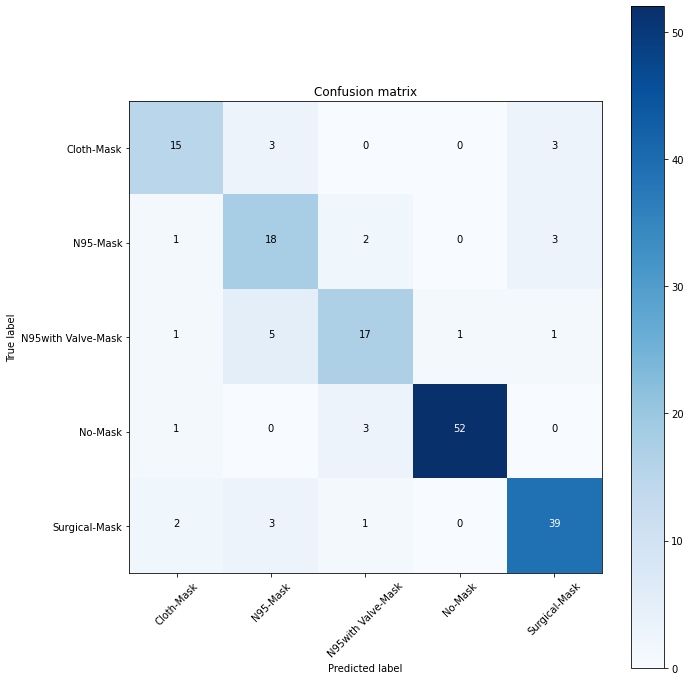

---------------------------
ELDER

Testing:
Correct prediction: 35/37 and accuracy: 0.9459459459459459 and loss: 0.005111553717634288
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      0.89      0.94         9
          N95-Mask       0.71      1.00      0.83         5
N95with Valve-Mask       1.00      1.00      1.00         6
           No-Mask       1.00      0.88      0.93         8
     Surgical-Mask       0.89      0.89      0.89         9

          accuracy                           0.92        37
         macro avg       0.92      0.93      0.92        37
      weighted avg       0.93      0.92      0.92        37

Confusion matrix, without normalization
[[8 0 0 0 1]
 [0 5 0 0 0]
 [0 0 6 0 0]
 [0 1 0 7 0]
 [0 1 0 0 8]]


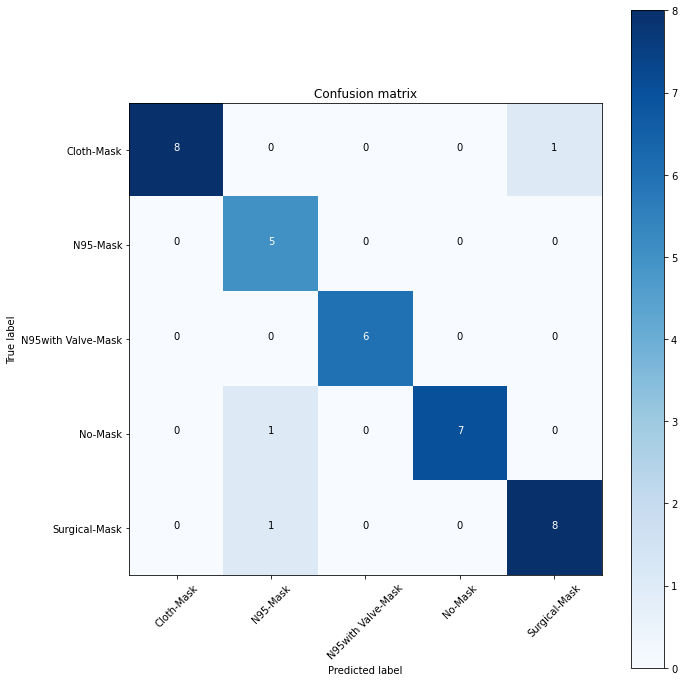

---------------------------
For Model 2 

MALE

Testing:
Correct prediction: 21/24 and accuracy: 0.875 and loss: 0.014529019594192505
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      0.40      0.57         5
          N95-Mask       0.67      1.00      0.80         4
N95with Valve-Mask       0.75      0.75      0.75         4
           No-Mask       1.00      1.00      1.00         6
     Surgical-Mask       0.67      0.80      0.73         5

          accuracy                           0.79        24
         macro avg       0.82      0.79      0.77        24
      weighted avg       0.83      0.79      0.78        24

Confusion matrix, without normalization
[[2 0 1 0 2]
 [0 4 0 0 0]
 [0 1 3 0 0]
 [0 0 0 6 0]
 [0 1 0 0 4]]


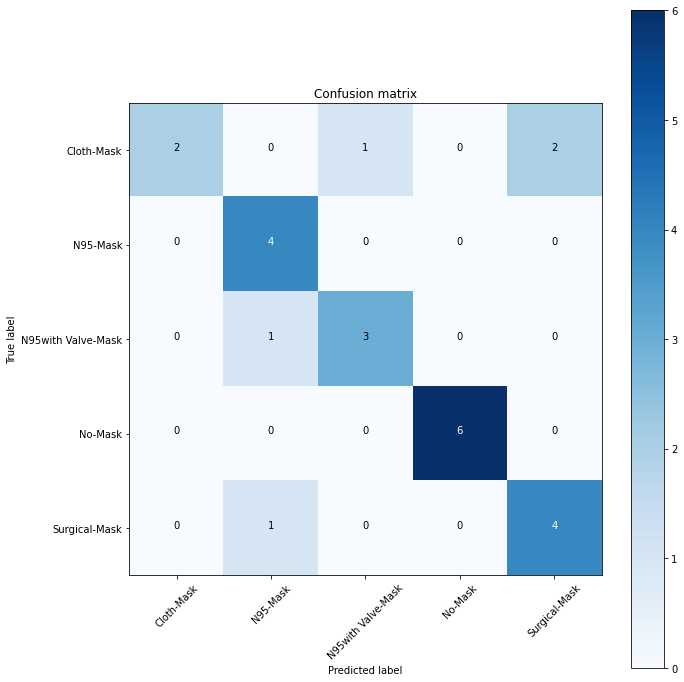

---------------------------
FEMALE

Testing:
Correct prediction: 31/39 and accuracy: 0.7948717948717948 and loss: 0.05540963625296568
                    precision    recall  f1-score   support

        Cloth-Mask       0.89      0.89      0.89         9
          N95-Mask       0.80      0.89      0.84         9
N95with Valve-Mask       0.86      0.75      0.80         8
           No-Mask       1.00      0.86      0.92         7
     Surgical-Mask       0.71      0.83      0.77         6

          accuracy                           0.85        39
         macro avg       0.85      0.84      0.84        39
      weighted avg       0.85      0.85      0.85        39

Confusion matrix, without normalization
[[8 0 1 0 0]
 [0 8 0 0 1]
 [0 2 6 0 0]
 [0 0 0 6 1]
 [1 0 0 0 5]]


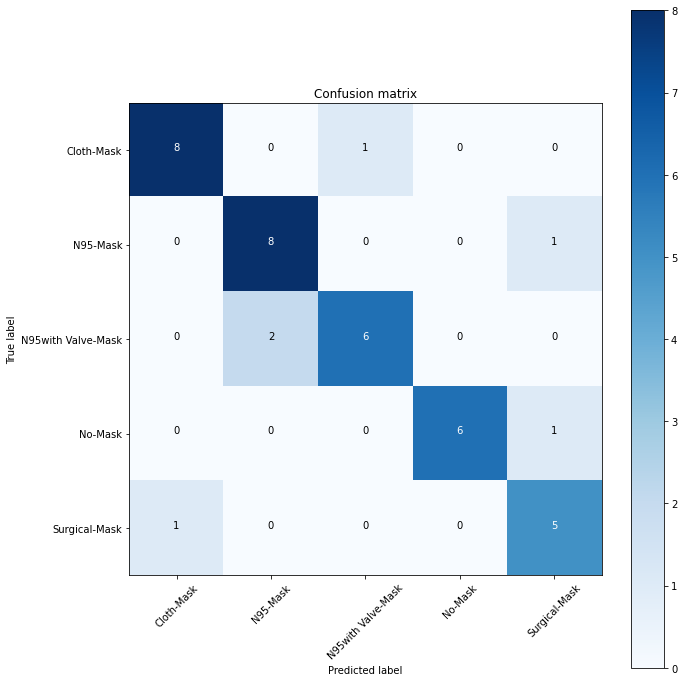

---------------------------
KIDS

Testing:
Correct prediction: 52/60 and accuracy: 0.8666666666666667 and loss: 0.01757527788480123
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      0.57      0.72        23
          N95-Mask       0.25      1.00      0.40         2
N95with Valve-Mask       0.62      0.83      0.71         6
           No-Mask       1.00      1.00      1.00        25
     Surgical-Mask       0.67      1.00      0.80         4

          accuracy                           0.82        60
         macro avg       0.71      0.88      0.73        60
      weighted avg       0.92      0.82      0.83        60

Confusion matrix, without normalization
[[13  5  3  0  2]
 [ 0  2  0  0  0]
 [ 0  1  5  0  0]
 [ 0  0  0 25  0]
 [ 0  0  0  0  4]]


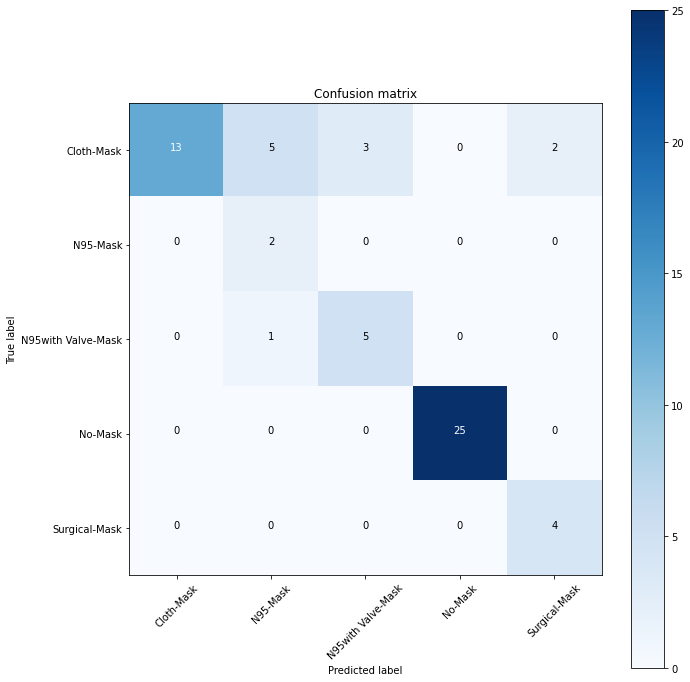

---------------------------
ADULTS

Testing:
Correct prediction: 155/171 and accuracy: 0.9064327485380117 and loss: 0.010238485726696707
                    precision    recall  f1-score   support

        Cloth-Mask       0.75      0.71      0.73        21
          N95-Mask       0.73      1.00      0.84        24
N95with Valve-Mask       0.96      0.96      0.96        25
           No-Mask       0.98      0.91      0.94        56
     Surgical-Mask       0.93      0.84      0.88        45

          accuracy                           0.89       171
         macro avg       0.87      0.89      0.87       171
      weighted avg       0.90      0.89      0.89       171

Confusion matrix, without normalization
[[15  2  1  1  2]
 [ 0 24  0  0  0]
 [ 0  1 24  0  0]
 [ 2  2  0 51  1]
 [ 3  4  0  0 38]]


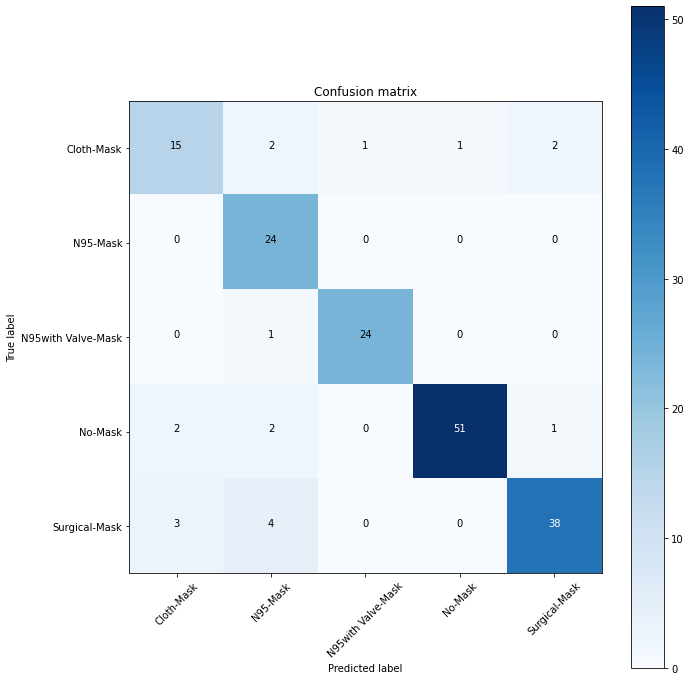

---------------------------
ELDER

Testing:
Correct prediction: 36/37 and accuracy: 0.972972972972973 and loss: 0.0017088848210216777
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      1.00      1.00         9
          N95-Mask       1.00      0.80      0.89         5
N95with Valve-Mask       1.00      1.00      1.00         6
           No-Mask       1.00      1.00      1.00         8
     Surgical-Mask       0.90      1.00      0.95         9

          accuracy                           0.97        37
         macro avg       0.98      0.96      0.97        37
      weighted avg       0.98      0.97      0.97        37

Confusion matrix, without normalization
[[9 0 0 0 0]
 [0 4 0 0 1]
 [0 0 6 0 0]
 [0 0 0 8 0]
 [0 0 0 0 9]]


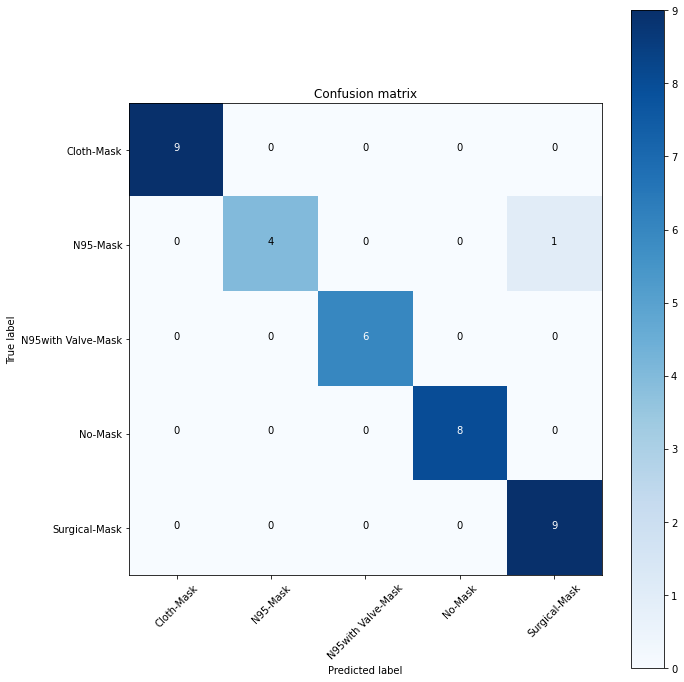

---------------------------
For Model 3 

MALE

Testing:
Correct prediction: 24/24 and accuracy: 1.0 and loss: 0.0020692719457050166
                    precision    recall  f1-score   support

        Cloth-Mask       0.83      1.00      0.91         5
          N95-Mask       1.00      0.75      0.86         4
N95with Valve-Mask       0.67      1.00      0.80         4
           No-Mask       1.00      0.83      0.91         6
     Surgical-Mask       1.00      0.80      0.89         5

          accuracy                           0.88        24
         macro avg       0.90      0.88      0.87        24
      weighted avg       0.91      0.88      0.88        24

Confusion matrix, without normalization
[[5 0 0 0 0]
 [0 3 1 0 0]
 [0 0 4 0 0]
 [1 0 0 5 0]
 [0 0 1 0 4]]


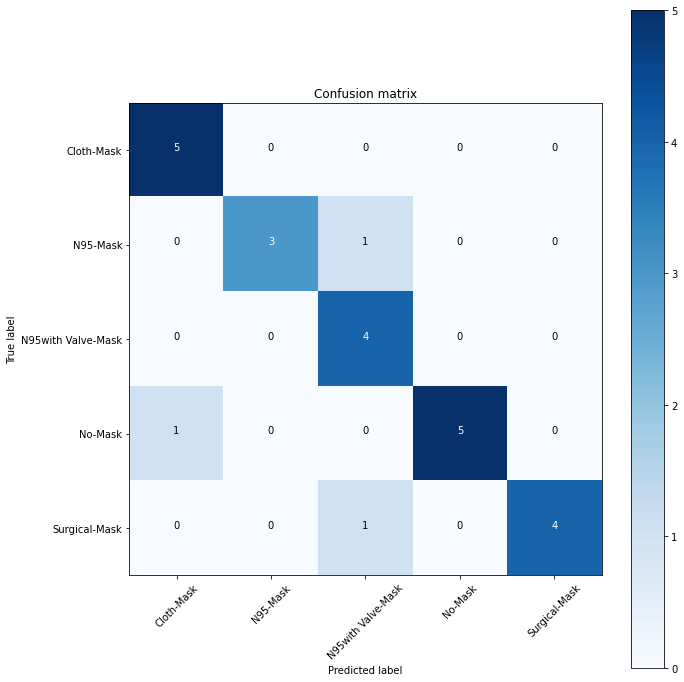

---------------------------
FEMALE

Testing:
Correct prediction: 35/39 and accuracy: 0.8974358974358975 and loss: 0.020207350452740986
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      1.00      1.00         9
          N95-Mask       0.89      0.89      0.89         9
N95with Valve-Mask       0.78      0.88      0.82         8
           No-Mask       1.00      0.86      0.92         7
     Surgical-Mask       0.83      0.83      0.83         6

          accuracy                           0.90        39
         macro avg       0.90      0.89      0.89        39
      weighted avg       0.90      0.90      0.90        39

Confusion matrix, without normalization
[[9 0 0 0 0]
 [0 8 1 0 0]
 [0 0 7 0 1]
 [0 0 1 6 0]
 [0 1 0 0 5]]


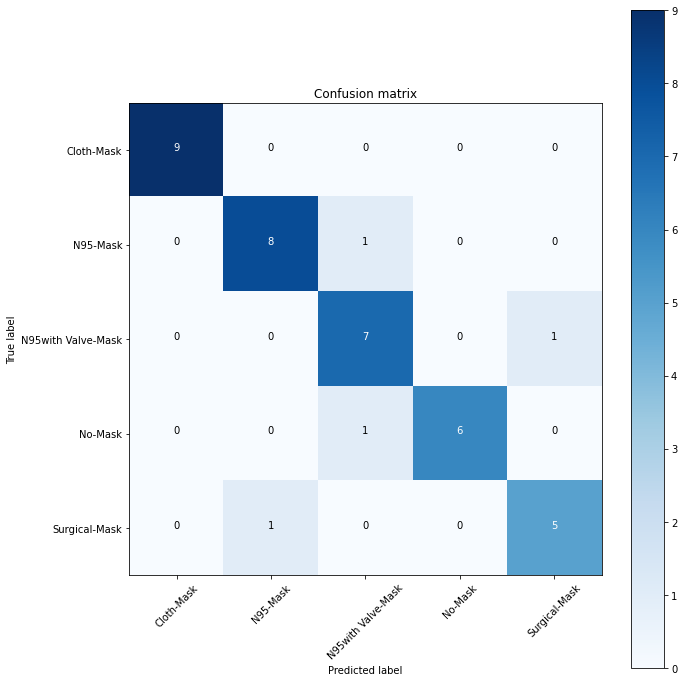

---------------------------
KIDS

Testing:
Correct prediction: 57/60 and accuracy: 0.95 and loss: 0.004550287391369542
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      0.96      0.98        23
          N95-Mask       1.00      1.00      1.00         2
N95with Valve-Mask       0.75      1.00      0.86         6
           No-Mask       1.00      0.96      0.98        25
     Surgical-Mask       1.00      1.00      1.00         4

          accuracy                           0.97        60
         macro avg       0.95      0.98      0.96        60
      weighted avg       0.97      0.97      0.97        60

Confusion matrix, without normalization
[[22  0  1  0  0]
 [ 0  2  0  0  0]
 [ 0  0  6  0  0]
 [ 0  0  1 24  0]
 [ 0  0  0  0  4]]


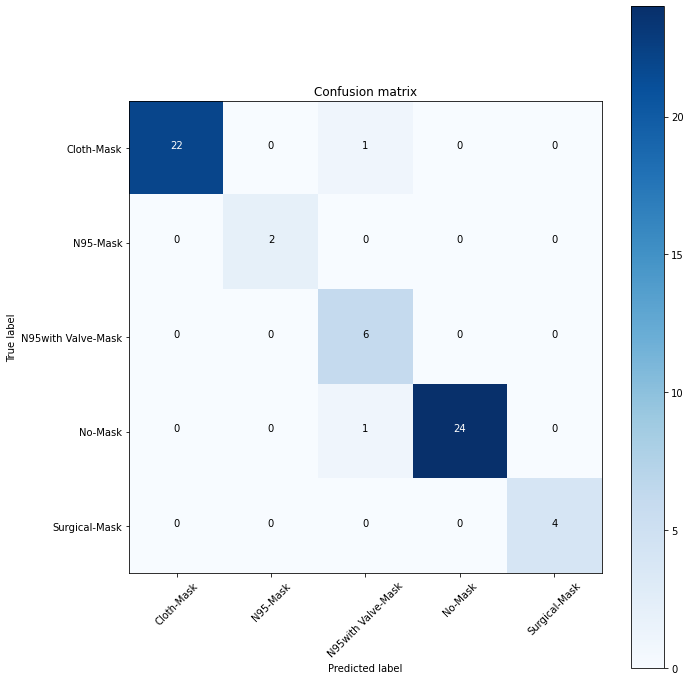

---------------------------
ADULTS

Testing:
Correct prediction: 154/171 and accuracy: 0.9005847953216374 and loss: 0.014427988544890755
                    precision    recall  f1-score   support

        Cloth-Mask       0.78      0.86      0.82        21
          N95-Mask       0.79      0.92      0.85        24
N95with Valve-Mask       0.96      0.92      0.94        25
           No-Mask       0.98      0.98      0.98        56
     Surgical-Mask       0.97      0.87      0.92        45

          accuracy                           0.92       171
         macro avg       0.90      0.91      0.90       171
      weighted avg       0.92      0.92      0.92       171

Confusion matrix, without normalization
[[18  2  0  0  1]
 [ 2 22  0  0  0]
 [ 1  1 23  0  0]
 [ 1  0  0 55  0]
 [ 1  3  1  1 39]]


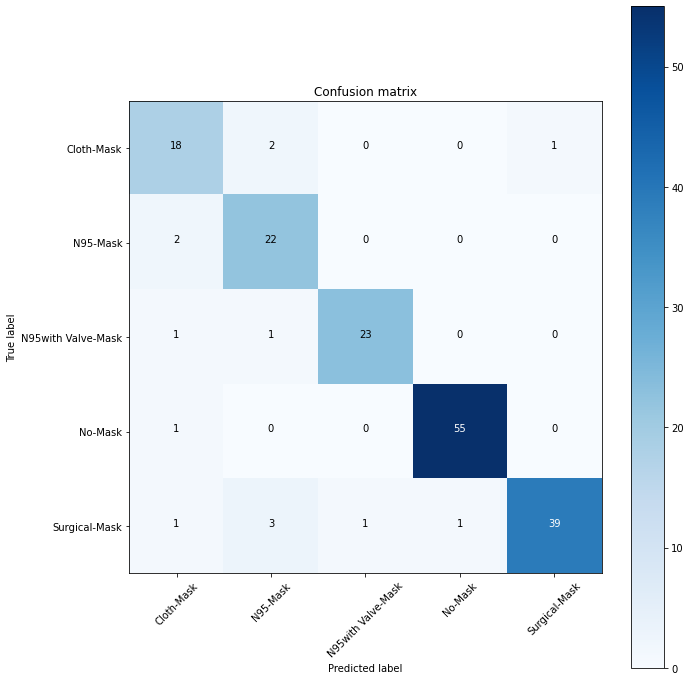

---------------------------
ELDER

Testing:
Correct prediction: 37/37 and accuracy: 1.0 and loss: 0.0009613111546354343
                    precision    recall  f1-score   support

        Cloth-Mask       0.90      1.00      0.95         9
          N95-Mask       1.00      0.80      0.89         5
N95with Valve-Mask       0.83      0.83      0.83         6
           No-Mask       1.00      0.88      0.93         8
     Surgical-Mask       0.90      1.00      0.95         9

          accuracy                           0.92        37
         macro avg       0.93      0.90      0.91        37
      weighted avg       0.92      0.92      0.92        37

Confusion matrix, without normalization
[[9 0 0 0 0]
 [1 4 0 0 0]
 [0 0 5 0 1]
 [0 0 1 7 0]
 [0 0 0 0 9]]


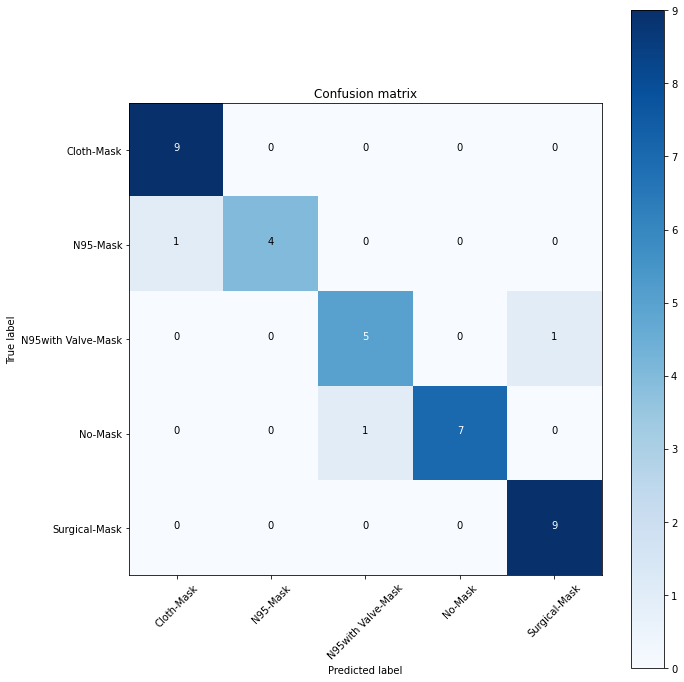

---------------------------
For Model 4 

MALE

Testing:
Correct prediction: 23/24 and accuracy: 0.9583333333333334 and loss: 0.0034040678292512894
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      1.00      1.00         5
          N95-Mask       0.80      1.00      0.89         4
N95with Valve-Mask       1.00      1.00      1.00         4
           No-Mask       1.00      0.83      0.91         6
     Surgical-Mask       1.00      1.00      1.00         5

          accuracy                           0.96        24
         macro avg       0.96      0.97      0.96        24
      weighted avg       0.97      0.96      0.96        24

Confusion matrix, without normalization
[[5 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 1 0 5 0]
 [0 0 0 0 5]]


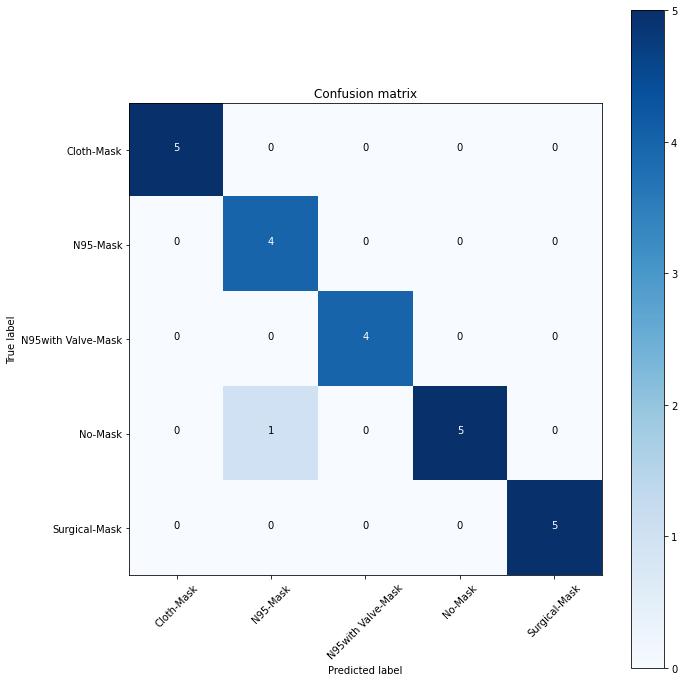

---------------------------
FEMALE

Testing:
Correct prediction: 34/39 and accuracy: 0.8717948717948718 and loss: 0.013544235091943007
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      1.00      1.00         9
          N95-Mask       1.00      1.00      1.00         9
N95with Valve-Mask       0.89      1.00      0.94         8
           No-Mask       1.00      0.86      0.92         7
     Surgical-Mask       1.00      1.00      1.00         6

          accuracy                           0.97        39
         macro avg       0.98      0.97      0.97        39
      weighted avg       0.98      0.97      0.97        39

Confusion matrix, without normalization
[[9 0 0 0 0]
 [0 9 0 0 0]
 [0 0 8 0 0]
 [0 0 1 6 0]
 [0 0 0 0 6]]


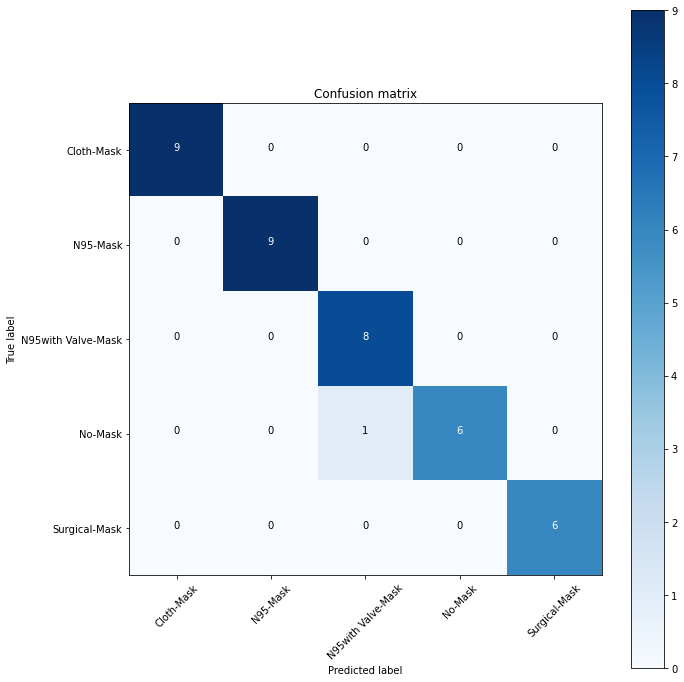

---------------------------
KIDS

Testing:
Correct prediction: 57/60 and accuracy: 0.95 and loss: 0.012556640555461247
                    precision    recall  f1-score   support

        Cloth-Mask       0.95      0.91      0.93        23
          N95-Mask       0.67      1.00      0.80         2
N95with Valve-Mask       0.71      0.83      0.77         6
           No-Mask       1.00      0.92      0.96        25
     Surgical-Mask       0.80      1.00      0.89         4

          accuracy                           0.92        60
         macro avg       0.83      0.93      0.87        60
      weighted avg       0.93      0.92      0.92        60

Confusion matrix, without normalization
[[21  0  1  0  1]
 [ 0  2  0  0  0]
 [ 1  0  5  0  0]
 [ 0  1  1 23  0]
 [ 0  0  0  0  4]]


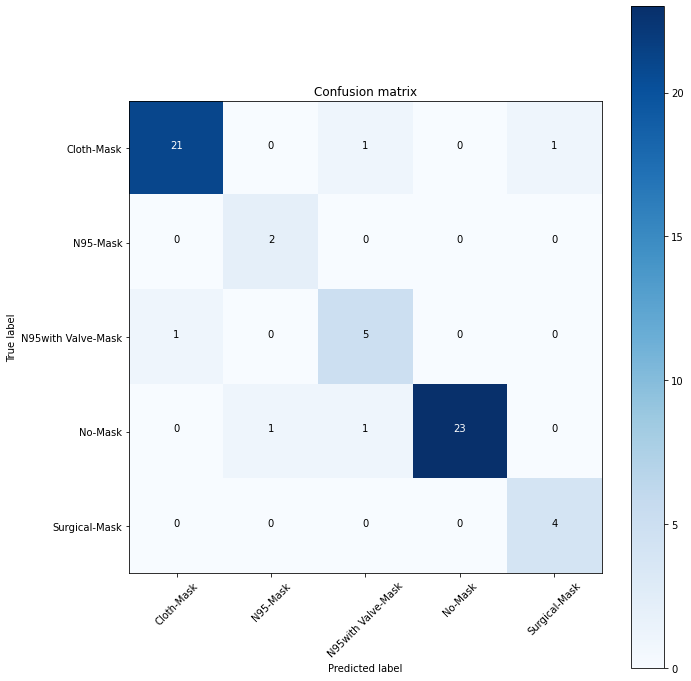

---------------------------
ADULTS

Testing:
Correct prediction: 149/171 and accuracy: 0.8713450292397661 and loss: 0.01723320538188979
                    precision    recall  f1-score   support

        Cloth-Mask       0.83      0.95      0.89        21
          N95-Mask       0.90      0.75      0.82        24
N95with Valve-Mask       0.77      0.96      0.86        25
           No-Mask       1.00      0.88      0.93        56
     Surgical-Mask       0.89      0.93      0.91        45

          accuracy                           0.89       171
         macro avg       0.88      0.89      0.88       171
      weighted avg       0.90      0.89      0.90       171

Confusion matrix, without normalization
[[20  0  1  0  0]
 [ 2 18  2  0  2]
 [ 0  0 24  0  1]
 [ 1  1  3 49  2]
 [ 1  1  1  0 42]]


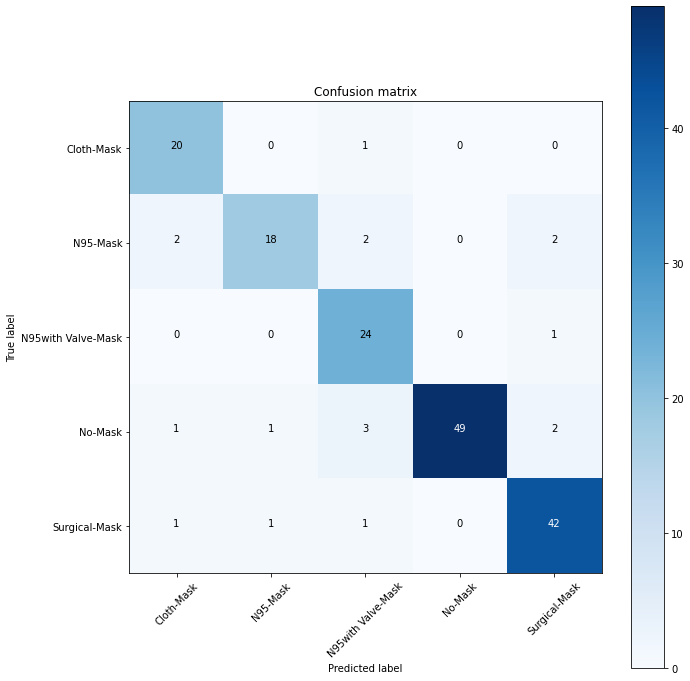

---------------------------
ELDER

Testing:
Correct prediction: 34/37 and accuracy: 0.918918918918919 and loss: 0.04003985508068188
                    precision    recall  f1-score   support

        Cloth-Mask       0.75      1.00      0.86         9
          N95-Mask       1.00      0.40      0.57         5
N95with Valve-Mask       0.83      0.83      0.83         6
           No-Mask       1.00      1.00      1.00         8
     Surgical-Mask       1.00      1.00      1.00         9

          accuracy                           0.89        37
         macro avg       0.92      0.85      0.85        37
      weighted avg       0.91      0.89      0.88        37

Confusion matrix, without normalization
[[9 0 0 0 0]
 [2 2 1 0 0]
 [1 0 5 0 0]
 [0 0 0 8 0]
 [0 0 0 0 9]]


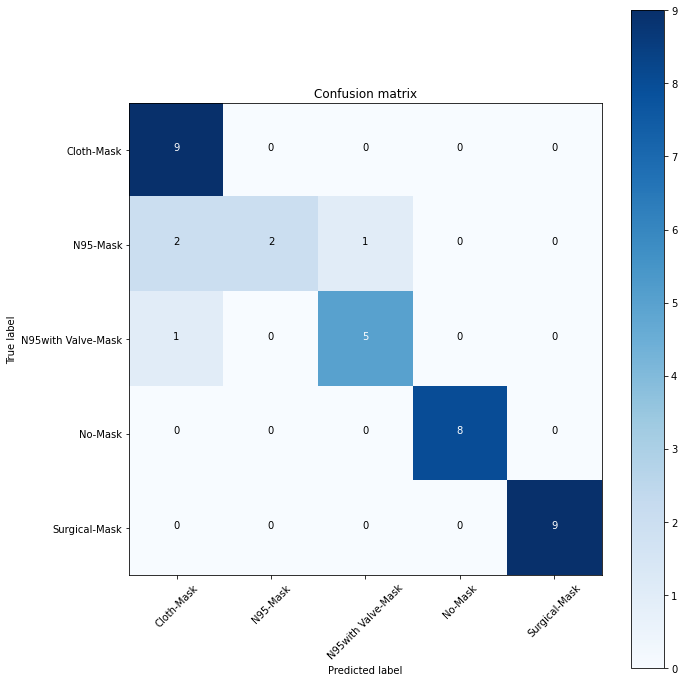

---------------------------
For Model 5 

MALE

Testing:
Correct prediction: 20/24 and accuracy: 0.8333333333333334 and loss: 0.023631930351257324
                    precision    recall  f1-score   support

        Cloth-Mask       0.75      0.60      0.67         5
          N95-Mask       0.80      1.00      0.89         4
N95with Valve-Mask       0.67      1.00      0.80         4
           No-Mask       1.00      0.83      0.91         6
     Surgical-Mask       1.00      0.80      0.89         5

          accuracy                           0.83        24
         macro avg       0.84      0.85      0.83        24
      weighted avg       0.86      0.83      0.83        24

Confusion matrix, without normalization
[[3 1 1 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [1 0 0 5 0]
 [0 0 1 0 4]]


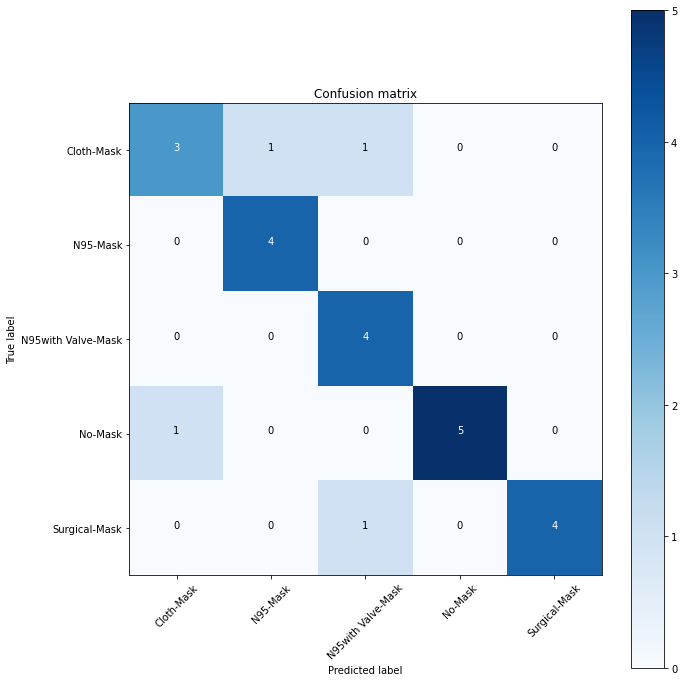

---------------------------
FEMALE

Testing:
Correct prediction: 37/39 and accuracy: 0.9487179487179487 and loss: 0.006308717796435723
                    precision    recall  f1-score   support

        Cloth-Mask       0.90      1.00      0.95         9
          N95-Mask       0.88      0.78      0.82         9
N95with Valve-Mask       0.88      0.88      0.88         8
           No-Mask       1.00      0.86      0.92         7
     Surgical-Mask       0.86      1.00      0.92         6

          accuracy                           0.90        39
         macro avg       0.90      0.90      0.90        39
      weighted avg       0.90      0.90      0.90        39

Confusion matrix, without normalization
[[9 0 0 0 0]
 [0 7 1 0 1]
 [1 0 7 0 0]
 [0 1 0 6 0]
 [0 0 0 0 6]]


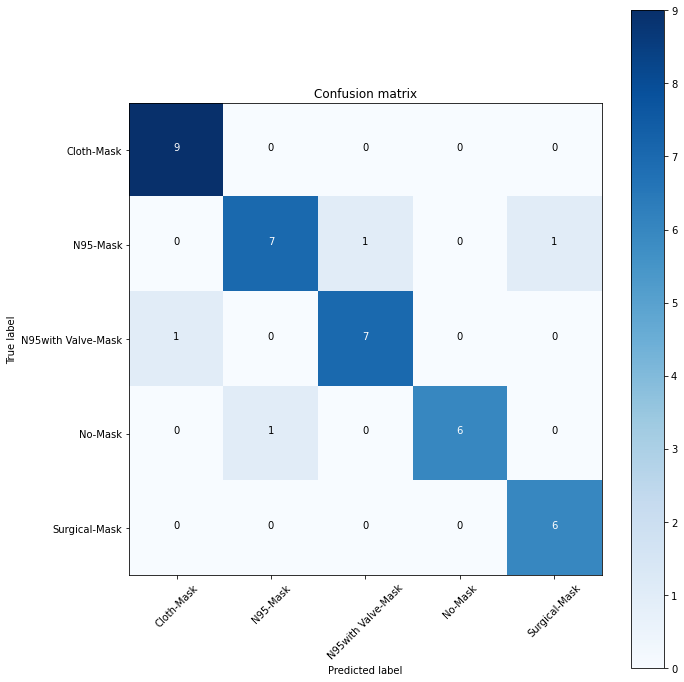

---------------------------
KIDS

Testing:
Correct prediction: 54/60 and accuracy: 0.9 and loss: 0.013042016079028447
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      0.91      0.95        23
          N95-Mask       0.50      1.00      0.67         2
N95with Valve-Mask       0.83      0.83      0.83         6
           No-Mask       1.00      0.96      0.98        25
     Surgical-Mask       0.80      1.00      0.89         4

          accuracy                           0.93        60
         macro avg       0.83      0.94      0.86        60
      weighted avg       0.95      0.93      0.94        60

Confusion matrix, without normalization
[[21  1  1  0  0]
 [ 0  2  0  0  0]
 [ 0  1  5  0  0]
 [ 0  0  0 24  1]
 [ 0  0  0  0  4]]


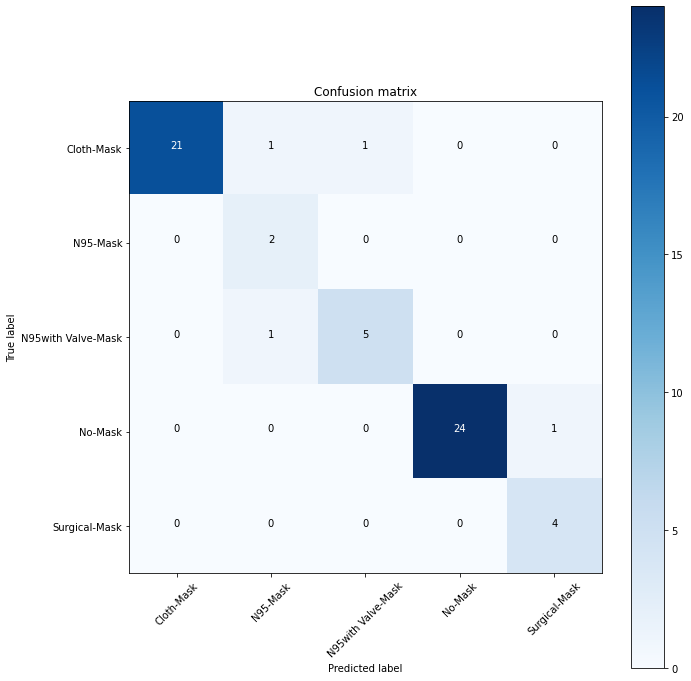

---------------------------
ADULTS

Testing:
Correct prediction: 163/171 and accuracy: 0.9532163742690059 and loss: 0.005646016900781651
                    precision    recall  f1-score   support

        Cloth-Mask       0.91      0.95      0.93        21
          N95-Mask       0.85      0.96      0.90        24
N95with Valve-Mask       0.84      0.84      0.84        25
           No-Mask       1.00      0.95      0.97        56
     Surgical-Mask       0.98      0.96      0.97        45

          accuracy                           0.94       171
         macro avg       0.92      0.93      0.92       171
      weighted avg       0.94      0.94      0.94       171

Confusion matrix, without normalization
[[20  0  1  0  0]
 [ 0 23  1  0  0]
 [ 2  2 21  0  0]
 [ 0  1  1 53  1]
 [ 0  1  1  0 43]]


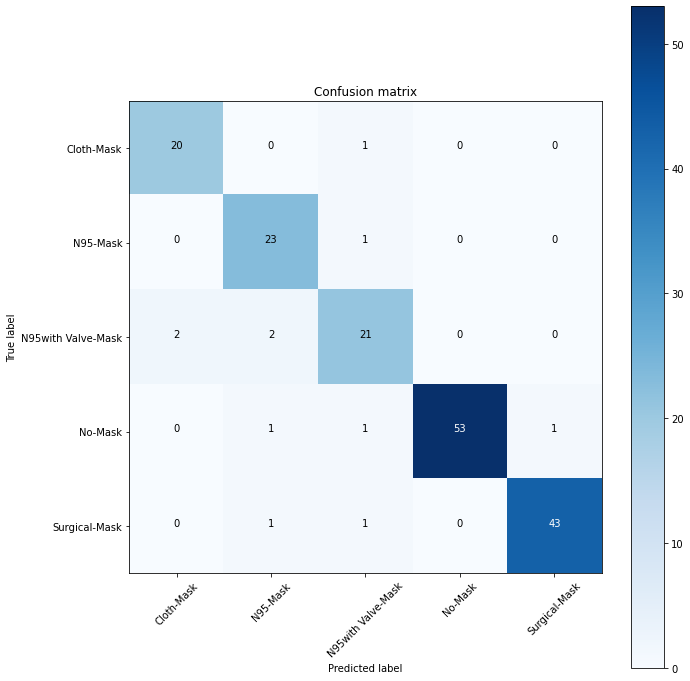

---------------------------
ELDER

Testing:
Correct prediction: 32/37 and accuracy: 0.8648648648648649 and loss: 0.038758825611423804
                    precision    recall  f1-score   support

        Cloth-Mask       1.00      1.00      1.00         9
          N95-Mask       0.83      1.00      0.91         5
N95with Valve-Mask       0.86      1.00      0.92         6
           No-Mask       1.00      0.88      0.93         8
     Surgical-Mask       1.00      0.89      0.94         9

          accuracy                           0.95        37
         macro avg       0.94      0.95      0.94        37
      weighted avg       0.95      0.95      0.95        37

Confusion matrix, without normalization
[[9 0 0 0 0]
 [0 5 0 0 0]
 [0 0 6 0 0]
 [0 1 0 7 0]
 [0 0 1 0 8]]


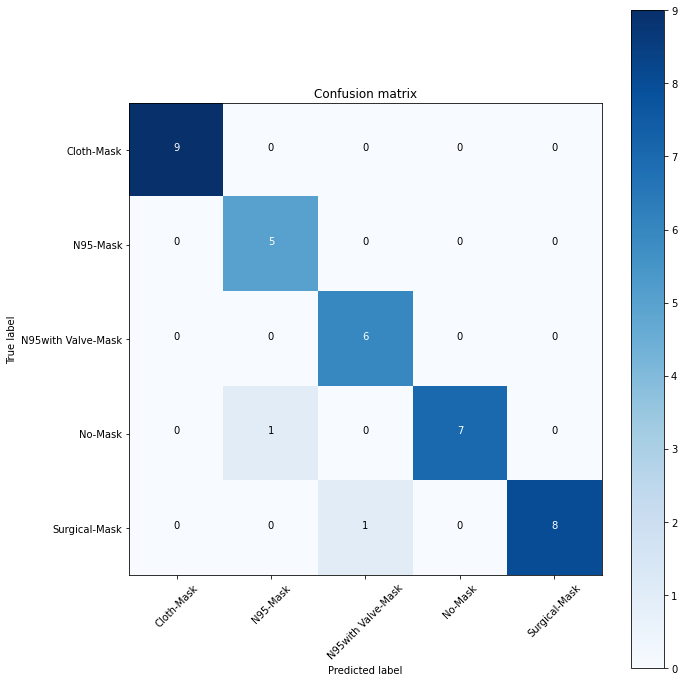

---------------------------


In [7]:
for i in range(0, 6):

    model = MaskNetV2()
    model = model.to(device)
    path = f"/content/drive/MyDrive/mask-classfication/saved_models/s1/masknetv2_k_fold::2{i}_full.pt"
    model = torch.load(path,torch.device('cpu'))

    print(f"For Model {i} \n")
    print('MALE')
    bias_measures_male.append(evaluate2(model, MALE,device))
    print('---------------------------')

    print('FEMALE')
    bias_measures_female.append(evaluate2(model, FEMALE,device))
    print('---------------------------')


    print('KIDS')
    bias_measures_teen.append(evaluate2(model, TEEN,device))
    print('---------------------------')

    print('ADULTS')
    bias_measures_adult.append(evaluate2(model, MEN,device))
    print('---------------------------')

    print('ELDER')
    bias_measures_old.append(evaluate2(model, OLD,device))
    print('---------------------------')

In [8]:
avg_acc_male = sum([x[0] for x in bias_measures_male]) / len(bias_measures_male)
avg_acc_female = sum([x[0] for x in bias_measures_female]) / len(bias_measures_female)
avg_acc_teen = sum([x[0] for x in bias_measures_teen]) / len(bias_measures_teen)
avg_acc_adult = sum([x[0] for x in bias_measures_adult]) / len(bias_measures_adult)
avg_acc_old = sum([x[0] for x in bias_measures_old]) / len(bias_measures_old)

In [9]:
print("Avg Accuracy Male :" + str(avg_acc_male))
print("Avg Accuracy Female: " + str(avg_acc_female))
print("Avg Accuracy Teen: " + str(avg_acc_teen))
print("Avg Accuracy Adult: " + str(avg_acc_adult))
print("Avg Accuracy Old: " + str(avg_acc_old))

Avg Accuracy Male :0.8958333333333334
Avg Accuracy Female: 0.8803418803418803
Avg Accuracy Teen: 0.9055555555555556
Avg Accuracy Adult: 0.8976608187134504
Avg Accuracy Old: 0.9324324324324325


In [10]:
avg_prec_male = sum([x[1] for x in bias_measures_male]) / len(bias_measures_male)
avg_prec_female = sum([x[1] for x in bias_measures_female]) / len(bias_measures_female)
avg_prec_teen = sum([x[1] for x in bias_measures_teen]) / len(bias_measures_teen)
avg_prec_adult = sum([x[1] for x in bias_measures_adult]) / len(bias_measures_adult)
avg_prec_old = sum([x[1] for x in bias_measures_old]) / len(bias_measures_old)

In [11]:
print("Avg Precision Male: " + str(avg_prec_male))
print("Avg Precision female: " + str(avg_prec_female))
print("Avg Precision Teen: " + str(avg_prec_teen))
print("Avg Precision Adult: " + str(avg_prec_adult))
print("Avg Precision Old: " + str(avg_prec_old))

Avg Precision Male: [0.80753968 0.78888889 0.76388889 1.         0.87777778]
Avg Precision female: [0.9462963  0.89398148 0.86044974 0.97916667 0.8452381 ]
Avg Precision Teen: [0.98365231 0.59722222 0.75099206 1.         0.76111111]
Avg Precision Adult: [0.78622344 0.79152748 0.83022246 0.99067403 0.91691625]
Avg Precision Old: [0.92314815 0.84126984 0.88730159 1.         0.92731481]


In [12]:
avg_recall_male = sum([x[2] for x in bias_measures_male]) / len(bias_measures_male)
avg_recall_female = sum([x[2] for x in bias_measures_female]) / len(bias_measures_female)
avg_recall_teen = sum([x[2] for x in bias_measures_teen]) / len(bias_measures_teen)
avg_recall_adult = sum([x[2] for x in bias_measures_adult]) / len(bias_measures_adult)
avg_recall_old = sum([x[2] for x in bias_measures_old]) / len(bias_measures_old)

In [13]:
print("Avg Recall Male: " + str(avg_recall_male))
print("Avg Recall Female: " + str(avg_recall_female))
print("Avg Recall Teen: " + str(avg_recall_teen))
print("Avg Recall Adult: " + str(avg_recall_adult))
print("Avg Recall Old: " + str(avg_recall_old))

Avg Recall Male: [0.76666667 0.875      0.875      0.80555556 0.83333333]
Avg Recall Female: [0.94444444 0.87037037 0.89583333 0.85714286 0.91666667]
Avg Recall Teen: [0.83333333 0.91666667 0.88888889 0.96       0.95833333]
Avg Recall Adult: [0.84126984 0.86111111 0.87333333 0.92261905 0.88148148]
Avg Recall Old: [0.96296296 0.8        0.88888889 0.91666667 0.92592593]


In [14]:
avg_fsc_male = sum([x[3] for x in bias_measures_male]) / len(bias_measures_male)
avg_fsc_female = sum([x[3] for x in bias_measures_female]) / len(bias_measures_female)
avg_fsc_teen = sum([x[3] for x in bias_measures_teen]) / len(bias_measures_teen)
avg_fsc_adult = sum([x[3] for x in bias_measures_adult]) / len(bias_measures_adult)
avg_fsc_old = sum([x[3] for x in bias_measures_old]) / len(bias_measures_old)

In [15]:
print("Avg Fscore Male: " + str(avg_fsc_male))
print("Avg Fscore Female: " + str(avg_fsc_female))
print("Avg Fscore Teen: " + str(avg_fsc_teen))
print("Avg Fscore Adult: " + str(avg_fsc_adult))
print("Avg Fscore Old: " + str(avg_fsc_old))

Avg Fscore Male: [0.75937951 0.81587302 0.80119048 0.88383838 0.85084175]
Avg Fscore Female: [0.94438711 0.8786048  0.87598039 0.90982906 0.87245532]
Avg Fscore Teen: [0.8958757  0.68611111 0.81074481 0.97930839 0.84444444]
Avg Fscore Adult: [0.81111256 0.81895566 0.84832766 0.95498706 0.8980702 ]
Avg Fscore Old: [0.93909611 0.78450253 0.88616939 0.95555556 0.92472194]


In [16]:
print(sum(avg_prec_male)/len(avg_prec_male))
print(sum(avg_prec_female)/len(avg_prec_female))
print(sum(avg_prec_teen)/len(avg_prec_teen))
print(sum(avg_prec_adult)/len(avg_prec_adult))
print(sum(avg_prec_old)/len(avg_prec_old))

0.8476190476190475
0.9050264550264548
0.8185955418850156
0.863112729934144
0.9158068783068783


In [17]:
print(sum(avg_recall_male)/len(avg_recall_male))
print(sum(avg_recall_female)/len(avg_recall_female))
print(sum(avg_recall_teen)/len(avg_recall_teen))
print(sum(avg_recall_adult)/len(avg_recall_adult))
print(sum(avg_recall_old)/len(avg_recall_old))

0.831111111111111
0.8968915343915344
0.9114444444444443
0.8759629629629628
0.8988888888888888


In [18]:
print(sum(avg_fsc_male)/len(avg_fsc_male))
print(sum(avg_fsc_female)/len(avg_fsc_female))
print(sum(avg_fsc_teen)/len(avg_fsc_teen))
print(sum(avg_fsc_adult)/len(avg_fsc_adult))
print(sum(avg_fsc_old)/len(avg_fsc_old))

0.8222246272246272
0.8962513381011833
0.843296891369981
0.8662906273921793
0.8980091036128188
